In [35]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T

In [36]:

print(torch.__version__)
print(torchaudio.__version__)

1.13.0
0.13.0


In [37]:
import os
from pydub import AudioSegment
from IPython.display import Audio
import librosa
import matplotlib.pyplot as plt
import numpy as np

In [38]:
_SAMPLE_DIR = "_assets"
os.makedirs(_SAMPLE_DIR, exist_ok=True)

In [39]:
#Get Information About the wav file

Pmetadata = torchaudio.info("_assets\monoSounds\The Weeknd VERSE SNIPET.wav")
print(Pmetadata)

AudioMetaData(sample_rate=48000, num_frames=752853, num_channels=1, bits_per_sample=16, encoding=PCM_S)


In [40]:
#Stereo to Mono

sound = AudioSegment.from_wav("_assets\The Weeknd VERSE SNIPET.wav")
sound = sound.set_channels(1)
sound.export("_assets\monoSounds\The Weeknd VERSE SNIPET.wav", format="wav")

<_io.BufferedRandom name='_assets\\monoSounds\\The Weeknd VERSE SNIPET.wav'>

In [41]:
#Sample Paths to Choose From

PIANO_PATH =  "_assets\monoSounds\Piano.wav"
OCARINA_PATH = "_assets\Ocarina.wav"
LILBABY_PATH = "_assets\monoSounds\Lil Baby.wav"
TREACHEROUS_PATH = "_assets\monoSounds\Treacherous Twins.wav"
TREACHEROUS_SNIPET_PATH = "_assets\monoSounds\snipet.wav"
SOUND500HZ_PATH = "_assets\sound500hz.wav"
SOUND4000HZ_PATH = "_assets\sound4000hz.wav"
THEWEEKND_FULL_VERSE_PATH = "_assets\monoSounds\The Weeknd VERSE FULL.wav"
THEWEEKND_SNIPET_VERSE_PATH = "_assets\monoSounds\The Weeknd VERSE SNIPET.wav"

In [42]:
TEST_PATH = THEWEEKND_SNIPET_VERSE_PATH

In [43]:
Pmetadata = torchaudio.info(TEST_PATH)
print(Pmetadata)

AudioMetaData(sample_rate=48000, num_frames=752853, num_channels=1, bits_per_sample=16, encoding=PCM_S)


In [44]:
#Function to plot the waveform of the audio file

def plot_waveform(waveform, sr, title="Waveform"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    figure, axes = plt.subplots(num_channels, 1)
    axes.plot(time_axis, waveform[0], linewidth=1)
    axes.grid(True)
    figure.suptitle(title)
    plt.show(block=False)

In [45]:
#Function to plot spectogram of audio file

def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

In [46]:
#Extract two components from the audio file
# 1 - Waveform
# 2 - SampleRate

SPEECH_WAVEFORM, SAMPLE_RATE = torchaudio.load(TEST_PATH)

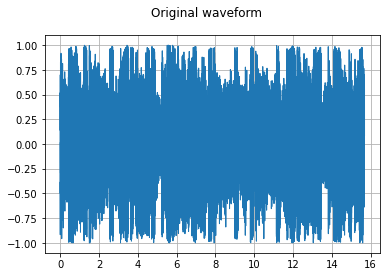

In [47]:
plot_waveform(SPEECH_WAVEFORM, SAMPLE_RATE, title="Original waveform")
Audio(SPEECH_WAVEFORM.numpy(), rate=SAMPLE_RATE)

In [48]:
#Spectogram preforms fft with the following parms

n_fft = 4096
win_length = None
hop_length = 512

# Define transform
spectrogram = T.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    window_fn=torch.hamming_window,
    center=True,
    pad_mode="reflect",
    power=2.0,
)

In [49]:
# Perform transform
spec = spectrogram(SPEECH_WAVEFORM)

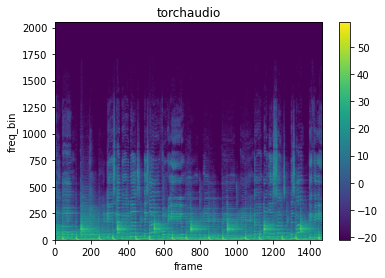

In [50]:
plot_spectrogram(spec[0], title="torchaudio")

In [51]:
# Perform a lowpass filter 
wvform = SPEECH_WAVEFORM
samplerate = 44100
cutofffreq = 5000

lowpass = F.lowpass_biquad(
    waveform=wvform,
    sample_rate=samplerate,
    cutoff_freq=cutofffreq
)

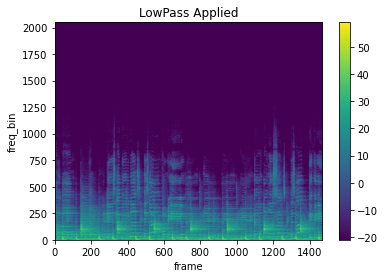

In [52]:
spec = spectrogram(lowpass)
plot_spectrogram(spec[0], title="LowPass Applied")

In [53]:
Audio(lowpass.numpy()[0], rate=samplerate)

In [54]:
# Downsampling from 44100 to 11025

sample_rate = 44100
resample_rate = 11025
resampler = T.Resample(sample_rate, resample_rate, dtype=lowpass.dtype)
resampled_waveform = resampler(lowpass)

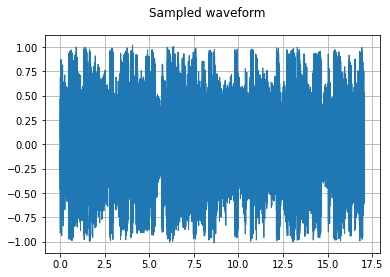

In [55]:
plot_waveform(resampled_waveform, resample_rate, title="Sampled waveform")
Audio(resampled_waveform.numpy()[0], rate=resample_rate)

In [56]:
n_fft = 1024
win_length = None
hop_length = 512

# Define transform
spectrogram = T.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    window_fn=torch.hamming_window,
    center=True,
    pad_mode="reflect",
    power=2.0,
)

In [57]:
# Perform transform
spec = spectrogram(resampled_waveform)

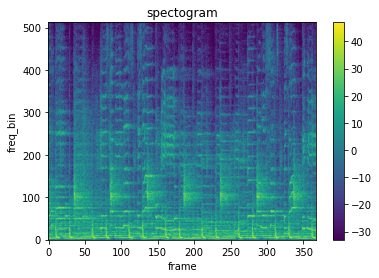

In [58]:
plot_spectrogram(spec[0], title="spectogram")

In [59]:
# Filtering
# Keep only strongest frequencies by bin
# Bins range: 0-10 // 10-20 // 20-40 // 40-80 // 80-160 // 160-512

def keyFrequency(Y):
    Y = Y[0].numpy()
    logBins = np.zeros((6,Y.shape[1]))
    X = Y.T
    for i in range(Y.shape[1]):
            logBins[0][i] = np.max(X[i][:11])
            logBins[1][i] = np.max(X[i][10:21])
            logBins[2][i] = np.max(X[i][20:41])
            logBins[3][i] = np.max(X[i][40:81])
            logBins[4][i] = np.max(X[i][80:161])
            logBins[5][i] = np.max(X[i][160:513])
    return torch.from_numpy(logBins)

In [60]:
X_nn = keyFrequency(spec)

In [61]:
X_nn.shape

torch.Size([6, 368])

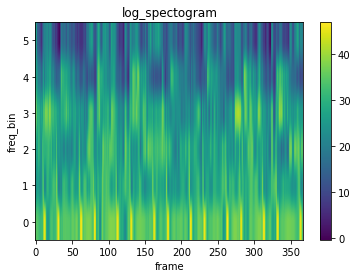

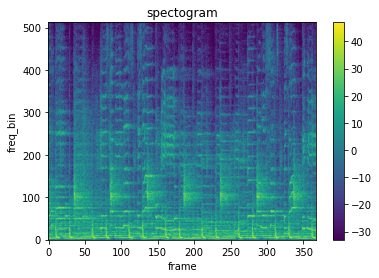

In [62]:
plot_spectrogram(X_nn, title="log_spectogram")
plot_spectrogram(spec[0], title="spectogram")

In [63]:
# Get Mean of most powerful bins

def meanBins(Y):
    sum = np.zeros(int(np.ceil(Y.shape[1]/215)))
    for i in range(int(np.ceil(Y.shape[1]/215))):
        sum += np.max(Y[i])
    return sum/6

In [64]:
# Keep most powerful bins

def maxBins(Y):
    Y= Y.numpy()
    s = np.zeros((6,Y.shape[1]))
    for i in range(6):
        mean = np.mean(Y[i])
        for j in range(Y.shape[1]):
            if Y[i][j] > mean*1.5:
                s[i][j] = 1
    return s

In [65]:
data = maxBins(X_nn)
a = np.where(data.astype(bool) == True)[1]
b = np.where(data.astype(bool) == True)[0]

In [66]:
# Get rid of clusters of strong frequencies

def deleteRepetitive(a,b):
    x_axis = []
    y_axis = []
    step = 0
    th = [1,6,8,10,15,20]
    for i in range(6):
        indices = np.argwhere(np.ediff1d(a[step : step + len(b[b == i])]) <= th[i]) + 1
        x_axis.append(np.delete(a[step : step + len(b[b == i])], indices))
        y_axis.append(np.delete(b[step : step + len(b[b == i])], indices))
        step = step +len(b[b == i])
    x_axis = [item for sublist in x_axis for item in sublist]
    y_axis = [item for sublist in y_axis for item in sublist]
    return np.array(x_axis),np.array(y_axis)

In [67]:
x_axis, y_axis = deleteRepetitive(a,b)

(-10.0, 378.0)

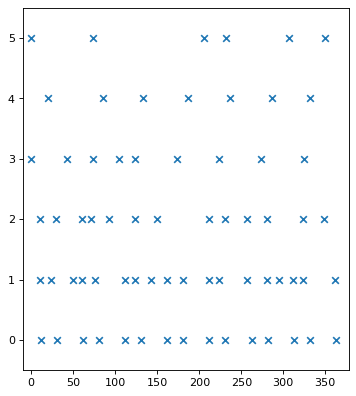

In [68]:
from matplotlib.pyplot import figure

figure(figsize=(data.shape[1]/70, 6), dpi=80)
plt.scatter(x=x_axis , y=y_axis, marker='x')
plt.ylim([-0.5, 5.5])
plt.xlim([-10, data.shape[1]+10]) 


Unique graph based on the audio. Afterwards, we compare graphs and assess similarities.